## Analyzing the Iraq War

Author: Edwin Bosch

In [15]:
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup

This project was created to analyze the consequences of the 2003-2011 U.S. invasion of Iraq known as the Iraq War. This war came at tremendous cost to the people of Iraq and the US soldiers sent there to fight. The costs of the war to the United States, while significant in both financial and human cost, are fairly well established and understood. Thus, I feel it is first important to analyze the war from the perspective of the citizens of Iraq. One of the most definitive sources of information is the Iraq Body Count project. This is a compilation of news sources reporting confirmed Iraqi deaths along with an effort to record the cause of death. Please be aware that the data is disturbing and violent in nature.

Given the overwhelming variety of causes of death, a good way to begin analysis is to look at a word cloud to better understand the descriptions of what happened.

In [16]:
df = pd.read_csv("ibc_data.csv", parse_dates=['End Date'])

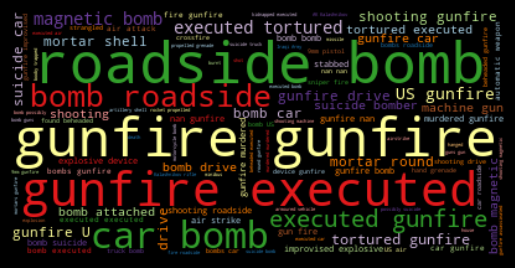

In [17]:
combined_text = ' '.join(list(df['Weapons'].astype(str)))

# remove stop words
stop_words_s = set(stopwords.words('english'))
stop_words_s.update(STOPWORDS)

# generate word cloud
wordcloud = WordCloud(background_color='black', stopwords=stop_words_s, colormap="Paired", random_state=142).generate(combined_text)

# plot the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.style.use('dark_background')
plt.show()

Gunfire is such an overwhelming occurrence and cause of death that it clouds out other information. This is worth noting and is expounded upon later. For now, the word clouds below remove some of the most common terms to see some other forms of violence that occurred.

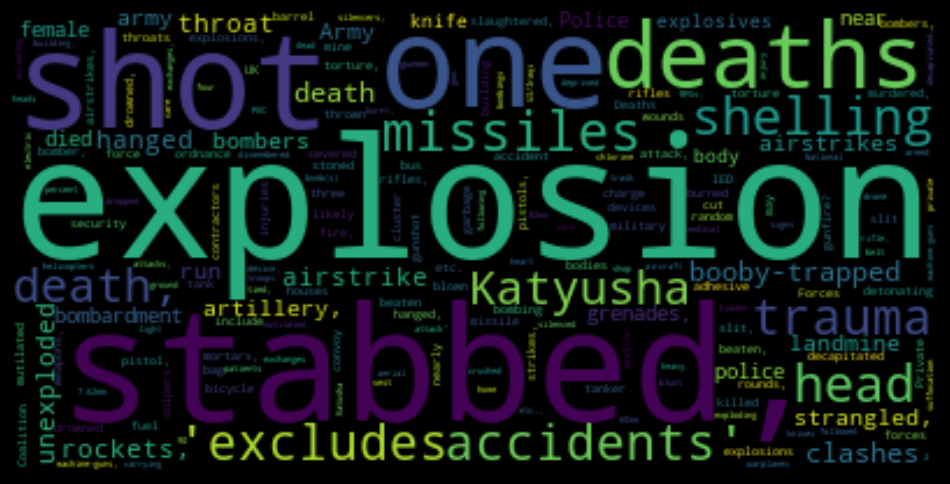

In [18]:
too_many_times = 100

# concatenate the text from the 'Weapons' column
text = ' '.join(df['Weapons'].astype(str))

# remove stopwords from the text
stopwords_s = set(stopwords.words('english'))
filtered_text = [word for word in text.split() if word.lower() not in stopwords_s]

# count the frequency of each word
word_freq = {}
for word in filtered_text:
    if word in word_freq:
        word_freq[word] += 1
    else:
        word_freq[word] = 1

# filter out words that occur more than the limit we have set
filtered_word_freq = {k: v for k, v in word_freq.items() if v <= too_many_times}

# generate word cloud
wordcloud = WordCloud(background_color='black', random_state=402).generate_from_frequencies(filtered_word_freq)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

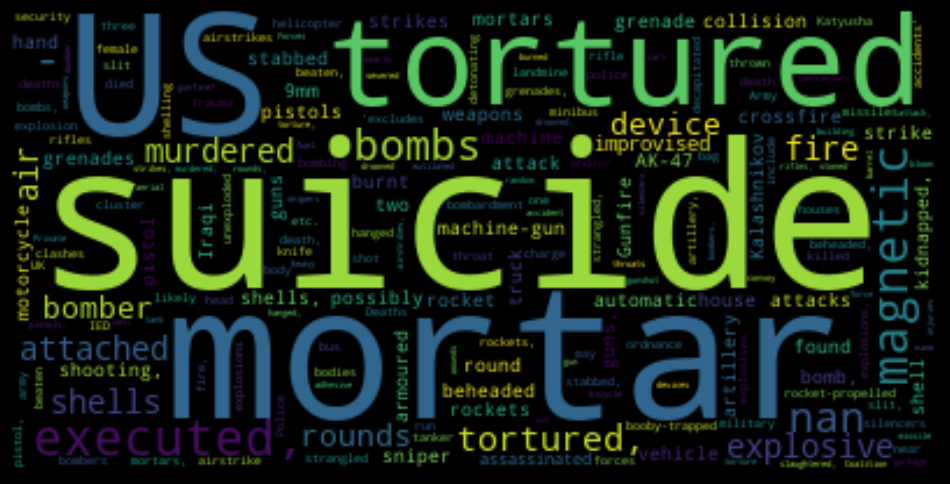

In [19]:
too_many_times = 2000

# concatenate the text from the 'Weapons' column
text = ' '.join(df['Weapons'].astype(str))

# remove stopwords from the text
stopwords_s = set(stopwords.words('english'))
filtered_text = [word for word in text.split() if word.lower() not in stopwords_s]

# count the frequency of each word
word_freq = {}
for word in filtered_text:
    if word in word_freq:
        word_freq[word] += 1
    else:
        word_freq[word] = 1

# filter out words that occur more than the threshold
filtered_word_freq = {k: v for k, v in word_freq.items() if v <= too_many_times}

# generate word cloud
wordcloud = WordCloud(background_color='black', random_state=202).generate_from_frequencies(filtered_word_freq)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

This third word cloud is perhaps the most descriptive in visualizing the violence of the war. Mortars, suicide attacks, torture, execution, and US involvement are words that occur in almost every incident.

The cell below notes the difference between potential maximum and minimum number of deaths.

In [20]:
print("Minimum deaths:", df["Reported Minimum"].sum())
print("Maximum deaths:", df["Reported Maximum"].sum())

Minimum deaths: 171238
Maximum deaths: 190818


The next plot attempts to categorize the incidents based on the raw data.

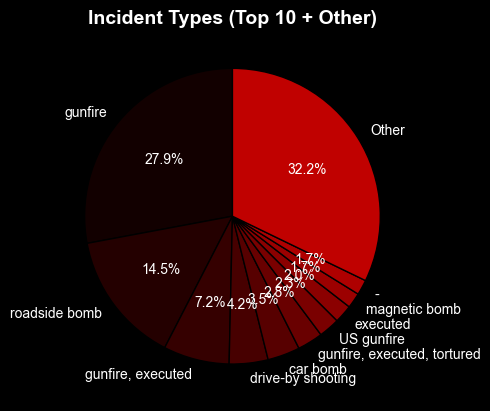

In [21]:
categories = 10

# Group the data by the "Weapons" column and count the number of occurrences of each weapon type
grouped = df.groupby("Weapons").size().reset_index(name='counts')

# Sort the grouped data by count in descending order
grouped = grouped.sort_values(by='counts', ascending=False)

# Get the 5 largest causes
top_cats = grouped.head(categories)

# Get the rest of the causes and group them into an "Other" category
other = grouped.tail(len(grouped) - categories)
other_sum = other["counts"].sum()
other = pd.DataFrame({"Weapons": ["Other"], "counts": [other_sum]})

# Combine the top 5 causes and the "Other" category
grouped = pd.concat([top_cats, other])

# Pie chart data
labels = grouped["Weapons"].tolist()
sizes = grouped["counts"].tolist()

# Plotting the pie chart
plt.pie(sizes, labels=labels, startangle=90, autopct='%1.1f%%', colors=plt.cm.gist_heat(np.linspace(0.05,0.5,len(labels))), textprops={'color': 'white'},wedgeprops={'linewidth': 1, 'edgecolor': 'black'})
plt.title("Incident Types (Top " + str(categories) + " + Other)", fontweight="bold", fontsize="14")

# Show the plot
plt.show()

As you can see there are many overlapping categories. The following chart attempts to categorize the incidents based on likely responsibility. There is not a perfect method for doing this and the function below is certainly open to criticism; however, it can give us some more insight.

In [22]:
# Define a function to get the perpetrator based on the event description
def get_perpetrator(description):
    description = str(description).lower()
    if ("us " in description and "minibus" not in description) or \
            "u.s." in description or \
            "uk" in description or \
            "us/iraqi" in description or \
            "f-16" in description or \
            "b-52" in description or \
            "coalition" in description or \
            "british" in description or \
            "australia" in description or \
            "icdc" in description or \
            "mortar" in description or \
            "air attack" in description or \
            "aerial bombardment" in description or \
            "airstrike" in description or \
            "air strike" in description or \
            "bombardment" in description or \
            "ermergency force" in description or \
            "hellfire" in description or \
            "iraqi intervention forces" in description or \
            "artillery" in description:
        return "US and Coalition Military"
    elif "insurgents" in description or \
            "adhesive" in description or \
            "ied" in description or \
            "katyusha" in description:
        return "Insurgents"
    elif "suicide" in description or \
            "executed" in description or \
            "decapitated" in description or \
            "isil" in description or \
            "torture" in description or \
            "dismember" in description or \
            "drive by" in description or \
            "beheaded" in description or \
            "car bomb" in description:
        return "Terrorism"
    # elif "iraqi " in description or \
    #         "national police" in description:
    #     return "Iraq Army"
    elif "explosive" in description or \
            "bomb" in description:
        return "Undetermined Explosions"
    elif "shot" in description or \
        "gun" in description or \
        "rifle" in description:
        return "Undetermined Gunfire"
    else:
        return "Unknown"

# Use apply() method to apply the function to the "Description" column
df['Perpetrator'] = df['Weapons'].apply(lambda x: get_perpetrator(x))

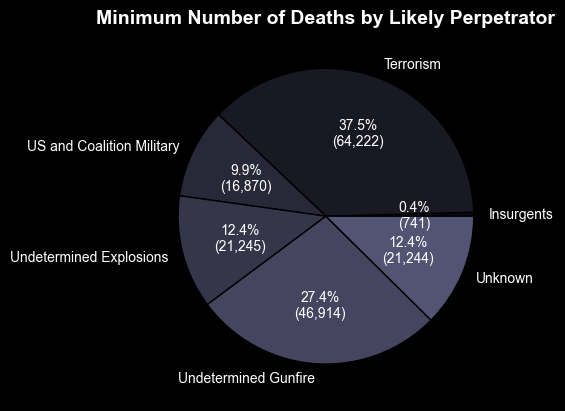

In [23]:
# calculate the minimum deaths for each perpetrator group
perpetrator_min_deaths = df.groupby('Perpetrator').agg({'Reported Minimum': 'sum'})

# plot a pie chart
plt.pie(perpetrator_min_deaths['Reported Minimum'], labels=perpetrator_min_deaths.index,
       autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100*perpetrator_min_deaths['Reported Minimum'].sum()):,})",
       colors=plt.cm.bone(np.linspace(0.05,0.7,len(labels))), textprops={'color': 'white'}, wedgeprops={'linewidth': 1, 'edgecolor': 'black'})
plt.title('Minimum Number of Deaths by Likely Perpetrator', fontweight="bold", fontsize="14")
plt.show()


The final method of analysis we will attempt for this data is time series analysis. That is, how the cause of deaths (again using our categorization function) varied over time.

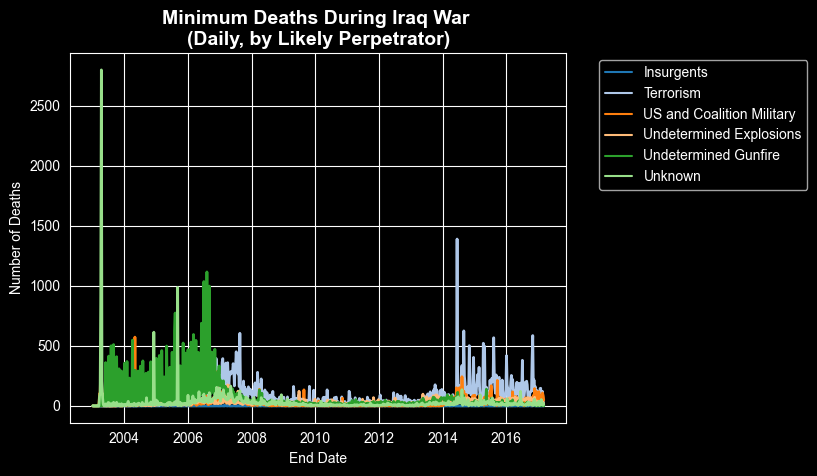

In [24]:
# Group data by end date and perpetrator
grouped = df.groupby(['End Date', 'Perpetrator'])['Reported Minimum'].sum().reset_index()

# Resample the data by week and sum the Reported Minimum values
grouped = grouped.set_index('End Date').groupby('Perpetrator').resample('W')['Reported Minimum'].sum().reset_index()

# Pivot data to wide format
pivoted = grouped.pivot(index='End Date', columns='Perpetrator', values='Reported Minimum').fillna(0)

# Create stacked area chart with a distinct color for each category
ax = sns.lineplot(data=pivoted, palette=sns.color_palette('tab20', n_colors=len(grouped['Perpetrator'].unique())), linewidth=2, dashes=False)

# Add labels and title
ax.set(xlabel='End Date', ylabel='Number of Deaths')
plt.title('Minimum Deaths During Iraq War \n(Daily, by Likely Perpetrator)', fontweight="bold", fontsize="14")
plt.legend(bbox_to_anchor=(1.5, 1.0), loc='upper right')

# Show plot
plt.show()

This first graph, while somewhat messy, gives an idea about the number of deaths that were occuring at a given time and what the primary causes were (at least according to the function defined above). We can see some outliers that might warrant further examination. The most notable was a single day with over 3000 Iraqi deaths. The code chunk below seeks to find that day.

In [25]:
# Group the data by day and sum the number of deaths for each day
deaths_by_day = df.groupby('End Date')['Reported Minimum'].sum()

# Find the day with the most deaths
max_day = deaths_by_day.idxmax()

# Find the number of deaths on the day with the most deaths
max_deaths = deaths_by_day[max_day]

# Print the results
print("Day with most deaths:", max_day)
print("Number of deaths on that day:", max_deaths)

Day with most deaths: 2003-04-09 00:00:00
Number of deaths on that day: 3074


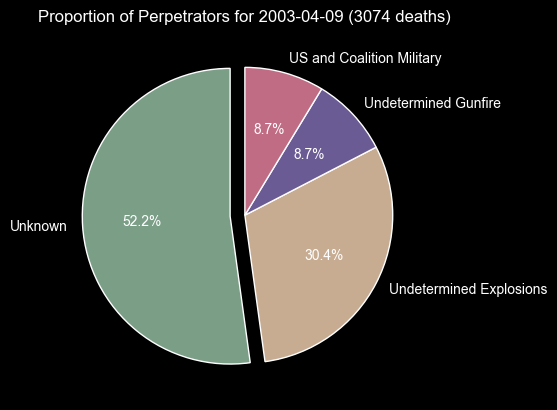

In [26]:
# Get the proportion of perpetrators for the most deaths day
most_deaths_day_data = df[df["End Date"] == max_day]
perpetrator_counts = most_deaths_day_data["Perpetrator"].value_counts()
perpetrator_labels = perpetrator_counts.index.tolist()
perpetrator_sizes = perpetrator_counts.values.tolist()

# Create a pie chart
colors = ["#7b9e87", "#c7ac92", "#6b5b95", "#c06c84", "#f67280", "#a7c5eb", "#dbd3e3"]
explode = (0.1, 0, 0, 0) # explode the largest slice
fig, ax = plt.subplots()
ax.pie(perpetrator_sizes, explode=explode, labels=perpetrator_labels, colors=colors, autopct="%1.1f%%", startangle=90, textprops={"color": "white"})
ax.set_title(f"Proportion of Perpetrators for {max_day.date()} ({max_deaths} deaths)")

plt.show()

This turns out not to be a coincidence. 4/9/2003 was the day now known as the "Fall of Baghdad".

"On April 9, 2003, just three weeks into the invasion of Iraq, U.S. forces pull down a bronze statue of Saddam Hussein in Baghdad’s Firdos Square, symbolizing the end of the Iraqi president’s long, often brutal reign, and a major early victory for the United States." <https://www.history.com/this-day-in-history/baghdad-falls-iraq-war>

To wrap up our time series analysis we can look at stacked area representations of total deaths by perpetrator over time.

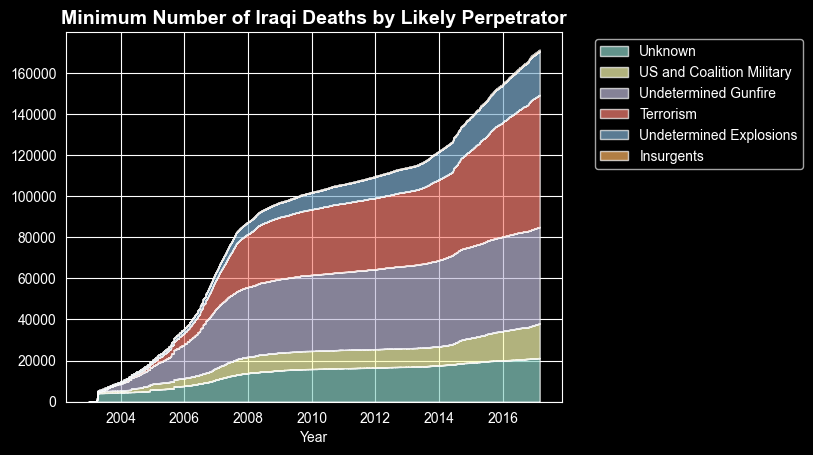

In [27]:
# reload data to create new columns
df = pd.read_csv("ibc_data.csv", parse_dates=['End Date'])
df['Perpetrator'] = df['Weapons'].apply(lambda x: get_perpetrator(x))

# Loop through each perpetrator and add a new column to the dataframe
df = df[::-1]
for p in df["Perpetrator"].unique():
    df[p] = df.apply(lambda x: x["Reported Minimum"] if x["Perpetrator"] == p else 0, axis=1).cumsum()

# Create a figure and axis object
fig, ax = plt.subplots()

# Get a list of the perpetrator columns
perp_cols = df.columns[11:]

# Create a stacked area chart
ax.stackplot(df["End Date"], *[df[c] for c in perp_cols], labels=perp_cols, alpha=0.7)

# Set the x-axis label and title
ax.set_xlabel("Year")
ax.set_title("Minimum Number of Iraqi Deaths by Likely Perpetrator", fontweight="bold", fontsize=14)
plt.legend(bbox_to_anchor=(1.5, 1.0), loc='upper right')
# Show the plot
plt.show()


## Costs to the United States

In [29]:
# web scraping
# URL of the webpage to scrape
url = 'http://icasualties.org/App/Fatalities?page=1&rows=0'

# Send a GET request and retrieve the webpage content
response = requests.get(url)
print(response)
content = response.content
print(content)

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(content, 'html.parser')

# Find the table that contains the data
table = soup.find('table', {'id': 'tblCasualties'})

# Extract the table headers
headers = [header.text.strip() for header in table.find_all('th')]

# Extract the table rows
rows = []
for row in table.find_all('tr')[1:]:
    rows.append([cell.text.strip() for cell in row.find_all('td')])

# Create a pandas DataFrame with the extracted data
df = pd.DataFrame(rows, columns=headers)

# Save the DataFrame as a CSV file
df.to_csv('us_casualties.csv', index=False)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



AttributeError: 'NoneType' object has no attribute 'find_all'